In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.functional as F
import json
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
torch.cuda.empty_cache()

In [3]:
def conv3x3(in_ch, out_ch, stride=1):
    """3x3 convolution with padding."""
    return nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1)

def conv1x1(in_ch, out_ch, stride=1):
    """1x1 convolution."""
    return nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride)

class ResidualBlockWithStride(nn.Module):
    """Residual block with a stride on the first convolution.

    Args:
        in_ch (int): number of input channels
        out_ch (int): number of output channels
        stride (int): stride value (default: 2)
    """

    def __init__(self, in_ch, out_ch, stride=2, inplace=False):
        super().__init__()
        self.conv1 = conv3x3(in_ch, out_ch, stride=stride)
        self.leaky_relu = nn.LeakyReLU(inplace=inplace)
        self.conv2 = conv3x3(out_ch, out_ch)
        self.leaky_relu2 = nn.LeakyReLU(negative_slope=0.1, inplace=inplace)
        if stride != 1:
            self.downsample = conv1x1(in_ch, out_ch, stride=stride)
        else:
            self.downsample = None

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.leaky_relu(out)
        out = self.conv2(out)
        out = self.leaky_relu2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out = out + identity
        return out

class IntraPredictorModel(nn.Module):
    def __init__(self, inplace=False):
        super().__init__()
        self.in_ch = 128
        self.h_ch = 16

        self.global_h = 16
        self.global_w = 16

        self.inner_dim = 128
    
        self.res_block = ResidualBlockWithStride(self.in_ch, self.h_ch, stride=2)
        self.global_pooling = nn.AdaptiveAvgPool2d((self.global_w, self.global_h))
        self.linear1 = nn.Linear(self.global_h * self.global_w * self.h_ch, self.inner_dim)
        self.leaky_relu = nn.LeakyReLU(inplace=inplace)
        self.linear2 = nn.Linear(self.inner_dim, 1)
        self.softmax = nn.Sigmoid()

    def forward(self, x):
        x = self.res_block(x)

        x = self.global_pooling(x)
        x = x.view(x.size(0), -1)
        x = self.linear1(x)
        x = self.leaky_relu(x)
        # x, _ = self.lstm(x)
        x = self.linear2(x)
        logits = self.softmax(x)

        return x, logits

In [ ]:
with open("../media/syntetic-low/long_large_predictor_dataset_0/reference_points.json", "r") as f:
    intra_ref_points = json.load(f)

In [ ]:
def enrich_ref_points(ref_points, distance=64):
    enriched = []
    all_points = set(ref_points)
    for idx in range(1, len(ref_points)):
        prev = ref_points[idx - 1]
        curr = ref_points[idx]
        all_points.update(np.arange(prev, curr, distance, dtype=int))
    
    return sorted([int(p) for p in all_points])

In [ ]:
all_ref_points = enrich_ref_points(intra_ref_points)

In [ ]:
all_ref_points = intra_ref_points

In [ ]:
frames_data = {
    "intra_frames": intra_ref_points,
    "refresh_frames": all_ref_points
}

with open("../media/syntetic-low/long_large_predictor_dataset_0/frames.json", "w") as f:
    json.dump(frames_data, f)


```python
frames_data = {
    "intra_frames": intra_ref_points,
    "refresh_frames": all_ref_points
}

with open("../media/syntetic/predictor_dataset_0/frames.json", "w") as f:
    json.dump(frames_data, f)
```

### Train loop with loaded inputs. 

Epochs should consist of going through the whole set of batches.
Batch is consisting of frames (contexts of those frames) within the range of the two neighboring reference points (`all_ref_points`).
Loss function is cross entropy between frame types (0 - non-reference, 1 - reference). Cross entropy should be weighted, so that the punishment for not guessing the reference frame is higher.

In [4]:
loaded = torch.load("../output/window_large_predictor_contexts_low/contexts.pth")

In [5]:
loaded = torch.cat([torch.zeros_like(loaded[0]).unsqueeze(0), loaded], dim=0).to(torch.float16)

In [6]:
# ref_frame_weight = 3

dist_alpha = 1
dist_beta = 1.2
non_ref_distribution = torch.distributions.Beta(dist_alpha, dist_beta)

def criterion_for_batch(batch_size, device='cpu'):
  weights = (torch.exp(non_ref_distribution.log_prob(torch.linspace(0, 1, batch_size - 1))) / (dist_alpha * 2)) + 0.5
  
  # Zero weight for random samples

  # downsample_rate = 0.7
  # weights = torch.random.shuffle(
  #   torch.cat([
  #     torch.ones()
  #   ])
  # )

  weights = torch.cat([weights, torch.tensor([batch_size / 4])]) / batch_size

  # Punish FP for 0s and FN for 1s
  # pos_weight = torch.ones_like(weights) * 5
  return nn.BCEWithLogitsLoss(weight=weights).to(device)

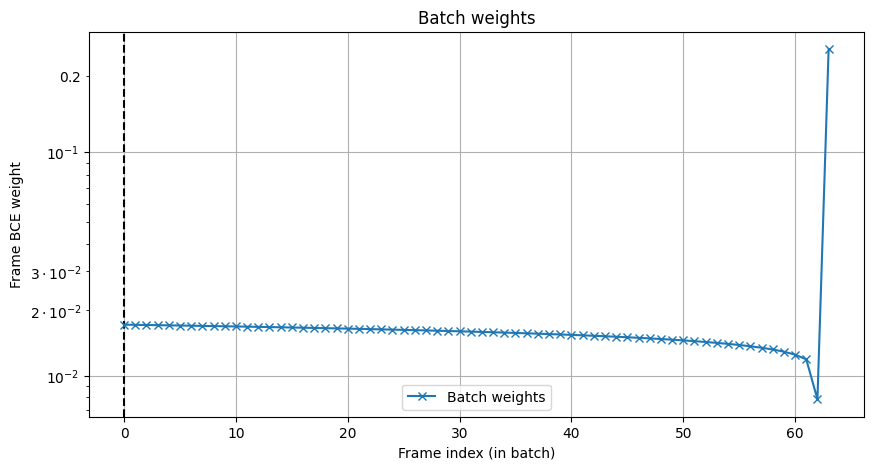

In [7]:
batch_size = 64
weights = (torch.exp(non_ref_distribution.log_prob(torch.linspace(0, 1, batch_size - 1))) / (dist_alpha * 2)) + 0.5
weights = torch.cat([weights, torch.tensor([batch_size / 4])]) / batch_size

plt.figure(figsize=(10, 5))

plt.yscale("logit")
plt.title("Batch weights")
plt.grid()
plt.axhline(0, color='k', linestyle='--')
plt.axvline(0, color='k', linestyle='--')

plt.plot(weights.numpy(), label="Batch weights", marker='x')
plt.xlabel("Frame index (in batch)")
plt.ylabel("Frame BCE weight")
plt.legend()
plt.show()

In [8]:
with open("../output/window_large_predictor_contexts_low/result.json", "r") as res_f:
  result_json = json.load(res_f)

In [9]:
all_ref_points = [1] + list(np.where(np.array(result_json['window_large_predictor_contexts_low']['long_large_predictor_dataset_0']['000']['frame_type']) > 1)[0] + 1)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
loaded = loaded.to(torch.float32).to(device)

In [12]:
train_proc = int(len(all_ref_points) * 0.8)
test_proc = len(all_ref_points) - train_proc

In [13]:
train_idx, test_idx = all_ref_points[:train_proc], all_ref_points[train_proc:]

In [15]:
def train(model, epochs, device, ref_points, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []

    for epoch in trange(epochs):
        epoch_loss = []
        train_indicies = list(range(1, len(ref_points)))
        np.random.shuffle(train_indicies)
        for idx in train_indicies:
            start_frame = max(ref_points[idx - 1] - 1, 1) # Skip first intra frame from sequence
            end_frame = ref_points[idx] - 1

            batch_size = end_frame - start_frame + 1
            criterion = criterion_for_batch(batch_size, device)

            batch = loaded[start_frame:end_frame + 1]

            # fst_frame = batch[0].unsqueeze(0)
            # batch = batch[1:]

            optimizer.zero_grad()
            output, _ = model(batch)
            true_labels = torch.cat([torch.zeros(batch_size - 1), torch.ones(1)]).to(torch.float32).to(device)

            # print("{} {}".format(output.squeeze(1).size(), true_labels.size()))
            # print("{}\n{}".format(output.squeeze(1), true_labels))

            loss = criterion(output.squeeze(1), true_labels)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
        
        losses.append(np.mean(epoch_loss))
        epoch_loss = []

        if epoch % 5 == 0:

            clear_output(wait=True)

            plt.figure(figsize=(15,15))

            plt.subplot(3, 1, 1)
            plt.plot(losses, label="Weighted BCELoss", linewidth=0.8, marker="x")
            plt.grid(True)
            plt.legend()
            plt.axhline(0, color="k", linestyle="--")
            plt.axvline(0, color="k", linestyle="--")

            plt.subplot(3, 1, 2)

            # with torch.no_grad():
            #     _, result = model(loaded[train_idx[0]], loaded[train_idx[0] + 1: train_idx[10]])
            #     result = result.detach().cpu()
            #     # plt.figure(figsize=(15,5))
            #     plt.grid(True)
            #     plt.scatter(torch.arange(train_idx[0] + 1, train_idx[10]), result, alpha=result.squeeze(1) / 10 * 8 + 0.2)
            #     for idx in train_idx[0:10]:
            #         plt.axvline(idx, c = 'r', alpha = 0.3)

            # plt.subplot(3, 1, 3)

            # with torch.no_grad():
            #     _, result = model(loaded[train_idx[-1]], loaded[train_idx[-1] + 1:])
            #     result = result.detach().cpu()
            #     # plt.figure(figsize=(15,5))
            #     plt.grid(True)
            #     plt.scatter(torch.arange(train_idx[-1] + 1, loaded.size(0)), result, alpha=result.squeeze(1) / 10 * 8 + 0.2)
            #     for idx in test_idx:
            #         plt.axvline(idx, c = 'r', alpha = 0.3)

            with torch.no_grad():
                _, result = model(loaded[train_idx[0]: train_idx[10]])
                result = result.detach().cpu()
                # plt.figure(figsize=(15,5))
                plt.grid(True)
                plt.scatter(torch.arange(train_idx[0], train_idx[10]), result, alpha=result.squeeze(1) / 10 * 8 + 0.2)
                for idx in train_idx[0:10]:
                    plt.axvline(idx, c = 'r', alpha = 0.3)

            plt.subplot(3, 1, 3)

            with torch.no_grad():
                _, result = model(loaded[train_idx[-1]:])
                result = result.detach().cpu()
                # plt.figure(figsize=(15,5))
                plt.grid(True)
                plt.scatter(torch.arange(train_idx[-1], loaded.size(0)), result, alpha=result.squeeze(1) / 10 * 8 + 0.2)
                for idx in test_idx:
                    plt.axvline(idx, c = 'r', alpha = 0.3)

            plt.show()


            print("Epoch: {} Loss: {}".format(epoch, losses[-1]))
    
    return losses

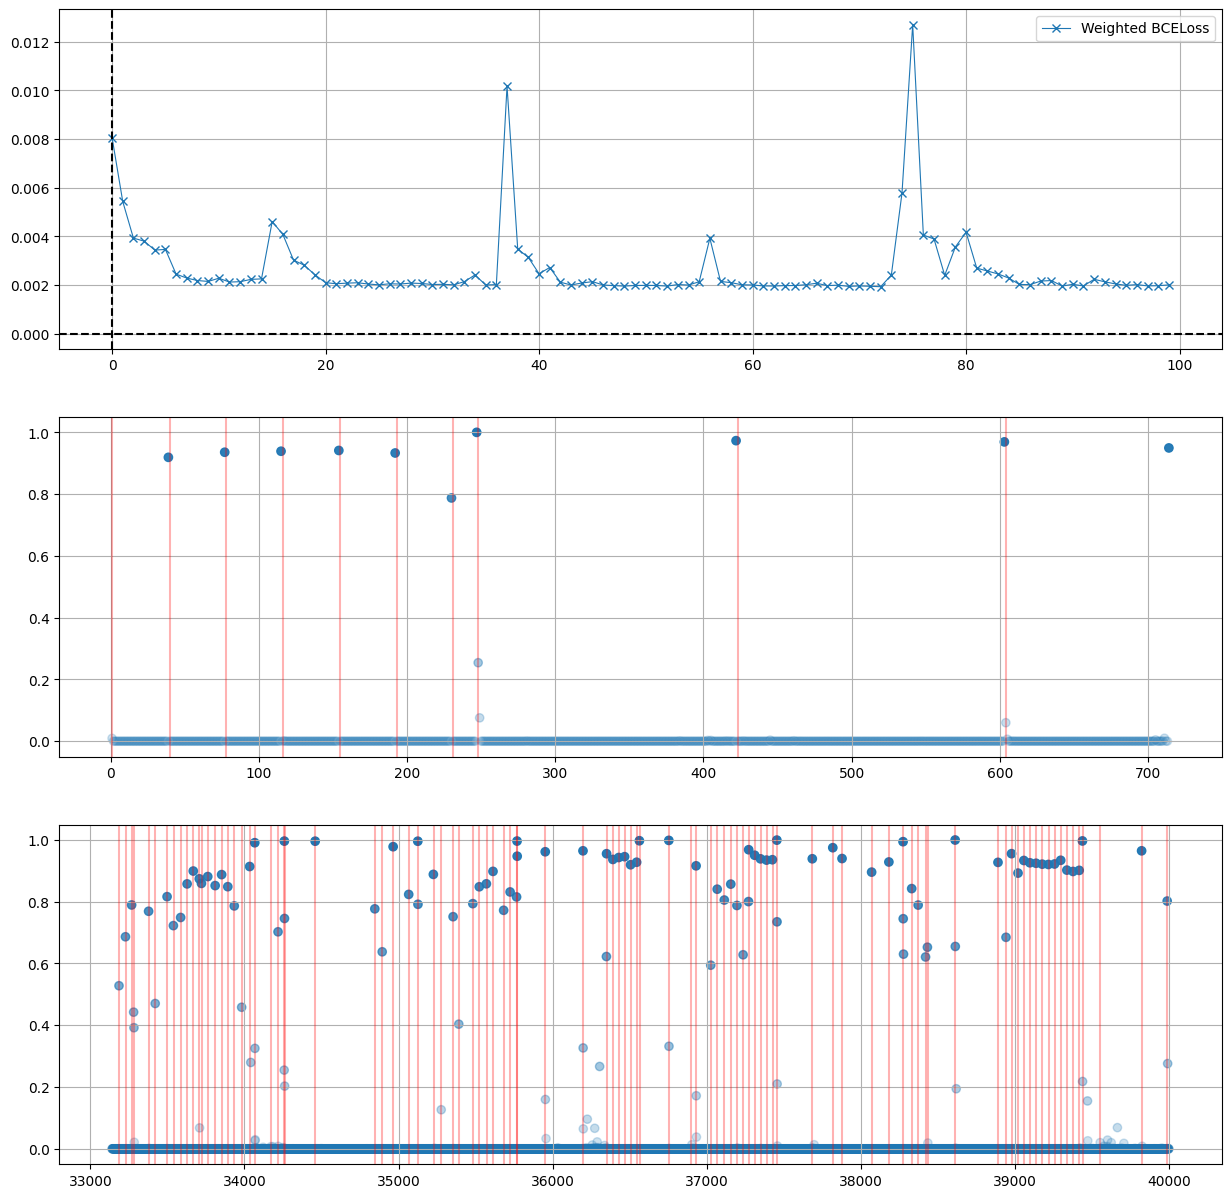

Epoch: 99 Loss: 0.002001598504467481


In [16]:
model = IntraPredictorModel().to(torch.float32).to(device)

l = train(model, 100, device, train_idx, lr = 1e-3)

In [17]:
from sklearn.metrics import f1_score, accuracy_score

In [18]:
last_train = train_idx[-1]

_, eval_result = model(loaded[last_train:])
eval_result = eval_result.detach().cpu().squeeze(1)

target = torch.zeros_like(eval_result)
target[torch.tensor(test_idx) - last_train - 1 ] = 1

In [19]:
currect_switches = (eval_result > 0.5)[torch.tensor(test_idx) - 1 - last_train].sum() / len(test_idx)

print(f"Proc of correct switches: {currect_switches:.2f}")

Proc of correct switches: 0.91


In [20]:
accuracy_score(target, eval_result > 0.5), f1_score(target, eval_result > 0.5)

(0.9973757107450065, 0.90625)

In [21]:
test_low = torch.load("../output/predictor_contexts_low/contexts.pth")
test_low = torch.cat([torch.zeros_like(test_low[0]).unsqueeze(0), test_low], dim=0).to(torch.float32).to(device)

In [22]:
with open("../media/syntetic-low/predictor_dataset_0/reference_points.json", "r") as f:
    test_ref_points = json.load(f)

# test_ref_points = enrich_ref_points(test_ref_points)

In [23]:
_, test_eval_result = model(test_low)
test_eval_result = test_eval_result.detach().cpu().squeeze(1)

test_target = torch.zeros_like(test_eval_result)
test_target[torch.tensor(test_ref_points) - 1] = 1

In [24]:
test_currect_switches = (test_eval_result > 0.8)[torch.tensor(test_ref_points) - 1].sum() / len(test_ref_points)

print(f"Proc of correct TEST switches: {test_currect_switches:.2f}")

Proc of correct TEST switches: 0.94


In [25]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1

    return(TP, FP, TN, FN)

In [26]:
train_measure = perf_measure(target, (eval_result > 0.5))

print("Train results: TP: {} FP: {} TN: {} FN: {}. Actual positives: {}".format(*train_measure, target.sum()))

Train results: TP: 87 FP: 9 TN: 6754 FN: 9. Actual positives: 96.0


In [27]:
test_measure = perf_measure(test_target, (test_eval_result > 0.9))

print("Test results: TP: {} FP: {} TN: {} FN: {}. Actual positives: {}".format(*test_measure, test_target.sum()))

Test results: TP: 16 FP: 7 TN: 2975 FN: 2. Actual positives: 18.0


In [28]:
# save model
model = model.to(torch.device('cpu'))
torch.save(model.state_dict(), "../checkpoints/decay_intra_predictor.pth")

In [6]:
# load_model

model = IntraPredictorModel()
model.load_state_dict(torch.load("../checkpoints/decay_intra_predictor.pth"))
model = model.to(device)

In [ ]:
x = list(range(0,10))

In [ ]:
np.percentile(x, 20)

In [ ]:
np.percentile(x[12:14], 50)